# Computando Integrais de Sommerfeld

Date: 2022-09-06  
Author: Pedro H. N. Vieira  
Categories: Sommerfeld, integração numérica  
Tags: julia, sommerfeld, integração numérica  
<!--eofm-->

In [1]:
using SpecialFunctions
using Plots


(process:13332): GLib-GIO-WARNING **: 09:28:04.730: Unexpectedly, UWP app `15191PeakPlayer.50533F9B98293_3.2.11.0_x64__y5c4dfz5b21fm' (AUMId `15191PeakPlayer.50533F9B98293_y5c4dfz5b21fm!App') supports 32 extensions but has no verbs


## Introdução

Em várias aplicações de eletromagnetismo, especialmente aqueles envolvendo dipolos harmônicos no tempo num plano horizontal estratificado, surgem Integrais de Sommerfeld (em [coordenadas cilíndricas](https://pt.wikipedia.org/wiki/Coordenadas_cil%C3%ADndricas)) da forma

$$
\int_0^\infty \tilde G(k_\rho ; z|z') J_\nu(k_\rho \rho) k_\rho \, dk_\rho, \quad \nu=0,1,2
$$

onde $\tilde G$ é a [função de Green](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Green) no domínio espectral, $z$ e $z'$ são as coordenadas verticais (perpendicular à estratificação) dos pontos de observação e da fonte, respectivamente, $\rho$ é a distância radial entre tais pontos, $J_\nu$ é [função de Bessel](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Bessel) de primeira espécie, $k_\rho$ é o [número de onda](https://pt.wikipedia.org/wiki/N%C3%BAmero_de_onda) da componente radial dela. Esta integral é, frequentemente, difícil de resolver por não ter solução em fórmula fechada, ser altamente oscilatória, singular e divergente. Para resolver estas integrais, revisaremos o artigo de [Michalski & Mosig (2016) [1]](#1).

A variável $k_\rho$ é complexa e há pontos sobre o eixo real (ou próximos dele) nos quais o integrando é singular. Portanto, faz-se a integração utilizando um caminho que evite tais pontos, como ilustrado abaixo. A altura (parte imaginária) desse caminho deve ser limitada de forma a evitar que a função de Bessel exploda (tenha valores muito elevados), pois isto pode levar a [erros de cancelamento catastrófico](https://pt.wikipedia.org/wiki/Cancelamento_catastr%C3%B3fico).

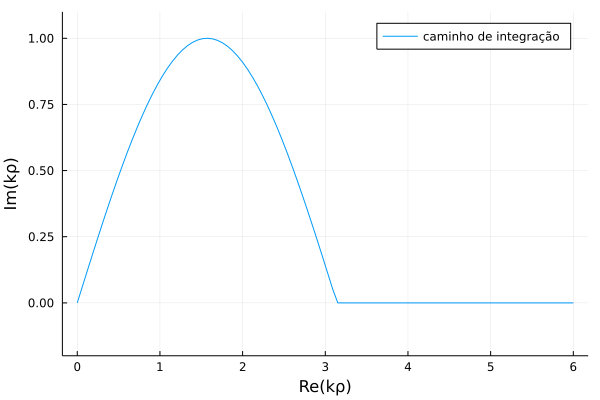

In [2]:
x = range(0, 6, length=100)
xd = 0
y = [xd < xi < pi + xd ? sin(xi - xd) : 0 for xi in x]
plot(x,y, ylims=(-0.2,1.1), xlabel="Re(kρ)", ylabel="Im(kρ)", label="caminho de integração")

Alternativamente, pode-se identificar os pontos no eixo $\Re(k_\rho)$ que tornam o integrando singular e fazer a integração em intervalos com alguma técnica capaz de lidar com singularidades nos pontos finais e iniciais como, por exemplo, a [quadratura de Gauss-Jacobi](https://en.wikipedia.org/wiki/Gauss%E2%80%93Jacobi_quadrature) ou a regra *tanh-sinh double exmponential (DE)*. Contudo, computar a cauda da integral (de $a$ até $\infty$) é mais complicado devido à natureza oscilatória de $\tilde G(k_\rho ; z|z')$, que tem a seguinte forma:

$$
\tilde G(k_\rho ; z|z') \sim \frac{e^{-k_\rho \zeta}}{k_\rho^\delta} [C + \mathcal{O}(k_\rho^{-1})], \quad k_\rho \to \infty
$$

onde $C$ é uma constante, $\zeta > 0$ é um parâmetro relacionado a $z$ e $z'$ (por exemplo, $\zeta = |z - z'|$ em um meio homogêneo) e $\mathcal{O}(k_\rho^{-1})$ é [um valor assintótico](https://pt.wikipedia.org/wiki/Grande-O).

## Regras de Exponenciais Duplas (DE)

O desenvolvimento da regras DE surge apartir da regra trapezoidal primitiv,

$$
\int_{-\infty}^{\infty} f(\xi) \, d\xi \approx h \sum_{k=-\infty}^{\infty} f(k h)
$$

onde $h>0$ e o erro de discretização é $\mathcal{O}(e^{-2\pi w/h})$ quando $h \to 0$, sendo $w$ a distância do eixo real para a singularidade mais próxima do integrando. Como a convergência é exponencial, dividindo $h$ pela metade faz dobrar o número de dígitos corretos no resultado para valore suficientimente pequenos de $h$.

### Intervalos Finitos

Para aplicar tal método a um intervalo finito, faz-se um mapa de $(-\infty,\infty)$ para $[-1,1]$ usando uma [função monótona](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_mon%C3%B3tona) $\varphi(t)$, tal que

$$
\int_{-1}^{1} f(\xi) \, d\xi = \int_{-\infty}^{\infty} f[\varphi(t)] \, \dot{\varphi}(t) \, dt \approx h \sum_{k=-n}^{n} \dot{\varphi}(k h)\,f[\varphi(kh)]
$$

onde $\dot{\varphi} \equiv d\varphi/dt$ é a Jacobiana da transformada. Usa-se uma transformada que force a derivada do integrando a zerar nos pontos extremos (finais). Pode-se escolher

$$
\varphi(t) = \tanh g(t) \\
\dot{\varphi}(t) = \dot{g}(t) \, \text{sech}^2 g(t)
$$

onde $g(t)$ é uma [função ímpar](https://pt.wikipedia.org/wiki/Paridade_de_fun%C3%A7%C3%B5es) que leva a

$$
\int_{-1}^{1} f(\xi) \, d\xi \approx h \sum_{k=-n}^{n} w_k f(\xi_k)
$$

sendo

$$
\xi_k = 1 - \delta_k \\
w_k = 2\, \dot{g}(kh) \, \delta_k \, (1 + q_k)^{-1} \\
\delta_k = 2\,q_k\,(1 + q_k)^{-1} \\
q_k = e^{-2\,g(kh)}
$$

Usando o fato que $\xi_{-k} = -\xi_k$ e $w_{-k} = w_k$, podemos expressar a integração por

$$
\int_{-1}^{1} f(\xi) \, d\xi \approx h \left \{ \dot{g}(0) \, f(0) + \sum_{k=1}^{n} w_k \left [ f(-1 + \delta_k) + f(+1 - \delta_k) \right ] \right \}.
$$

Um intervalo arbitrário $[a,b]$ pode ser mapeado em $[-1,1]$ pela transformada linear
$$\xi = \sigma\,x+\gamma \\ \sigma=(b-a)/2 \\ \gamma = (a+b)/2,$$ resultando em:

$$
\int_a^b f(\xi)\,d\xi = \sigma \int_{-1}^1 f(\sigma \, x + \gamma)\,dx
$$

$$
\int_{a}^{b} f(\xi) \, d\xi \approx \sigma h \left \{ \dot{g}(0) \, f(\gamma) + \sum_{k=1}^{n} w_k \left [ f(a + \sigma\,\delta_k) + f(b - \sigma\,\delta_k) \right ] \right \}.
$$

A função $g(t)$ pode ser escolhida tal que
$$
g(t) = \eta \sinh t, \quad \dot{g}(t) = \eta \cosh t,
$$
a qual dá origem à *regra tanh-sinh*, onde $\eta$ é um parâmetro positivo. A Jacobiana $\dot{g}(t)$ desta transformada tem decaimento duplo-exponencial para $t \to \pm \infty$. É recomendado escolher $\eta=1$ por conveniência, pois a transformada é, praticamente, insensível a valores de $\eta$ próximos da unidade. Para um $n$ fixo, recomenda-se escolher $h \approx \log(\pi^2 n) / n$ o qual, para $\eta = 1$, leva a um erro total da ordem de $\mathcal{O}(e^{-\pi^2 n / \log(\pi^2 n)})$.

Algo que torna este método de integração estranho é que ele não é exato para nenhum polinômio, nem sequer para uma constante, contudo, ele é notavelmente acurado. Outra característica deste método é que uma amostragem uniforme no eixo $t$ leva a um agrupamento dos nós $\xi_k$ perto dos pontos extremos do intervalo de integração, o qual, devido ao decaimento rápido dos pesos $w_k$, permite uma supressão de qualquer singularidade nos pontos extremos de $f(\xi)$.

Para estimar o erro, arbitra-se um tamanho inicial de malha $h$, dobra-se o número de pontos a cada iteração (fazendo $h_{k+1} = h_k / 2$), pois, assim, pode-se reutilizar os pontos calculados na iteração anterior, até que se atinja a convergência especificada $\epsilon$, isto é, são feitas sucessivas iterações $k$ até que a condição seguinte seja satisfeita. Tipicamente, o erro real será $\epsilon^2$ após a convergência.

$$
|T_n| < \epsilon \left | T_0 + \sum_{k=1}^n T_k \right |, \quad n =1,2,3,\dots
$$

Não há porquê implementarmos esse algoritmos, pois é possível encontrarmos códigos prontos por aí. Vamos instalar e usar o pacote [DoubleExponentialFormulas](https://github.com/machakann/DoubleExponentialFormulas.jl).

In [3]:
try
    using DoubleExponentialFormulas
catch ArgumentError
    using Pkg
    Pkg.add(url="https://github.com/machakann/DoubleExponentialFormulas.jl.git")
    using DoubleExponentialFormulas
end

In [4]:
rho = pi / 2
f(xi) = besselj0(xi * rho) * xi / sqrt(1 - xi^2)
@show sin(rho) / rho
@time I, E = quadde(f, 0, 1)  # tempo para executar, resultado, erro

sin(rho) / rho = 0.6366197723675814
  0.056668 seconds (9.27 k allocations: 551.336 KiB, 51.81% compilation time)


(0.6366197684453159, 3.400455970975599e-16)

In [5]:
rho = 53 * pi / 2
f(xi) = besselj0(xi * rho) * xi / sqrt(1 - xi^2)
@show sin(rho) / rho
@time I, E = quadde(f, 0, 1)  # tempo para executar, resultado, erro

sin(rho) / rho = 0.012011693818256251
  0.014545 seconds (2.06 k allocations: 32.266 KiB)


(0.012011692687093027, 8.819873915084412e-13)

### Intervalos Semi-infinitos

Para um intervalo semi-infinito $[a,\infty)$, uma transformada DE mista apropriada é

$$
\xi \leftarrow \varphi(t) = a + e^{t - \exp(-t)} \\
\dot{\varphi}(t) = (1 + e^{-t})\, e^{t - \exp(-t)}
$$

a qual leva a

$$
\int_a^\infty d(\xi) d\xi \approx h \sum_{k=-n_1}^{n_2} w_k \, f(a + \delta_k)
$$

com abscissas e pesos dados por

$$
\delta_k = e^{kh - \exp(-kh)} \\
w_k = (1 + e^{-kh}) \, \delta_k
$$

Note que, devido à falta de simetria da transformada, o somatório não pode ser "dobrado" em $k=0$ como para os interfalos finitos. Assim sendo, as somas parciais devem ser calculadas para $k$ positivo e negativo, separadamente.

O [DoubleExponentialFormulas](https://github.com/machakann/DoubleExponentialFormulas.jl) é perfeitamente capaz de lidar com intervalos infinitos e semi-infinitos.

In [6]:
z = 0.011
f(xi) = exp(-sqrt(xi^2 - 1) * z) / sqrt(xi^2 - 1) * xi
@show 1 / z
@time I, E = quadde(f, 1, Inf)  # tempo para executar, resultado, erro

1 / z = 90.90909090909092
  0.083234 seconds (88.71 k allocations: 5.616 MiB, 98.53% compilation time)


(90.90909088815197, 3.3998851087053017e-13)

In [7]:
@time I, E = quadde(x -> 1/(1 + x^2), -Inf, Inf)

  0.711757 seconds (791.96 k allocations: 46.602 MiB, 2.63% gc time, 99.59% compilation time)


(3.141592653589795, 8.471916029661848e-15)

## Aceleração de Sequências por Extrapolação

Para computar a cauda das integrais de Sommerfeld, é interessante acelerar a convergência de uma série da forma

$$
S_n = \sum_{i=0}^n u_i, \quad n\to \infty
$$

A sequência $S_n$ pode ser particionada como $S_n = S + r_n$, onde $r_n$ é o erro de truncamento dela, também chamado de *resto*. Busca-se uma transformada $\{S_n\} \to \{S_n'\}$ tal que a convergência seja mais rápida, isto é,

$$
\frac{|r_n'|}{|r_n|} = \mathcal{O}(x_n^{-\mu}), \quad \mu > 0, \quad n \to \infty
$$

A convergência destas séries pode ser caracterizada pelo limite <a name="lambda"></a>

$$
\lambda = \lim_{n\to\infty} \frac{r_{n+1}}{r_n} = \lim_{n\to\infty} \frac{u_{n+1}}{u_n}
$$

- Se $|\lambda| > 1$, a sequência diverge;
- Se $|\lambda| = 1$, a convergência é linear;
- Se $|\lambda| < 1$, a convergência é logarítmica;
- Se $|\lambda| = 0$, a convergência é hiperlinear;

O procedimento de extrapolação mais geral assume que o resto tem uma expansão assintótica

$$
r_n \sim \sum_{j=0}^\infty c_j \, \psi_j(n), \quad n \to \infty
$$

onde $c_j$ são coeficientes desconhecidos e $\psi_j(n)$ são funções arbitrárias, mas conhecidas de $n$, com a propriedade de $\psi_{j+1}=o(\psi_j(n))$. Para muitas sequências encontradas na prática, o resto tem uma expansão do tipo Poincaré da forma

$$
r_n \sim \omega_n \sum_{j=0}^\infty c_j \, x_n^{-j}, \quad n \to \infty
$$

onde $\omega_n$ são as estimativas do resto, que proveem a informação do comportamento de $r_n$ para $n$ grande, e $\{x_n\}$ é uma sequência auxiliar de pontos de interpolação tal que $x_{n+1}>x_n$. Os melhores aceleradores de convergência são obtidos tanto numericamente, quanto analiticamente, baseados no comportamento assintótico conhecido da sequência.

### A transformação de Levin e o algorítimo-W de Sidi

A transformação de Levin é baseada na expansão do tipo Poincaré do resto, conforme equacionado acima. Trunca-se a expansão assintótica depois de $k$ termos, onde $k$ é a ordem da transformada. Obtém-se, assim, o *modelo de sequência*

$$
S_n = S + \omega_n \sum_{j=0}^{k-1} c_j x_n^{-j}, \quad n \ge 0, k \ge 1,
$$

onde é assumido que as estimativas do resto $\omega_n$ e os pontos de interpolação $x_n$ são especificados. A transformada de Levin é construída para ser exata, tendo $k+1$ variáveis desconhecidas, i.e., o limite $S$ e os coeficientes $c_j$. Portanto, dada uma sequência de somas parciais $\{S_n, S_{n+1},\dots,S_{n+k}\}$, usa-se a equação acima para criar um sistema de $k+1$ equações lineares que é resolvido para encontrar $S$ usando-se a [regra de Cramer](https://pt.wikipedia.org/wiki/Regra_de_Cramer), o que fornece $S$ como a proporção de dois determinantes $(k+1) \times (K+1)$. Expandindo-se o numerador e denominador pelos [menores da primeira coluna](https://pt.wikipedia.org/wiki/Menor_(%C3%A1lgebra_linear)), chega-se a

$$
S_n^{(k)} = \sum_{j=0}^k \pi_n^{(k,j)} \frac{S_{n+j}}{\omega_{n+j}} \div \sum_{j=0}^k \pi_n^{(k,j)} \frac{1}{\omega_{n+j}}, \quad n \ge 0, k \ge 1, S_n^{(0)} = S_n
$$

onde

$$
\pi_n^{(k,j)} = \prod_{m=0 \\ m \ne j} \frac{1}{x_{n+m}^{-1} - x_{n+j}^{-1}}
$$

O subescrito no símbolo é o índice do elemento da sequência enquanto o sobrescrito denota a ordem da transformada. No caso de nós $x_n$ equidistantes, a última expressão pode ser especializada como

$$
\pi_n^{(k,j)} = (-1)^j \binom{k}{j} \left ( \frac{\beta + n + j}{\beta + n + k} \right )^{k-1}.
$$

As propriedades desta transformada (extrapolação) dependem das estimativas do resto $\omega_n$. Uma estimativa eficaz é dada por:

$$
\omega_n = \begin{cases} u_n \text{ ou } u_{n+1} &\text{(transformada t ou d)} \\ x_n u_n &\text{(transformada u)} \\ \frac{u_n u_{n+1}}{u_n - u_{n+1}} &\text{(transformada v)} \end{cases}
$$

sendo $u_n = S_n - S_{n-1}$. A transformada de Levin é não-linear, pois $\omega_n$ depende explicitamente de ao menos um elemento de $\{S_n\}$. A transformada t acelera convergência linear, enquanto as transformadas u e v são mais versáteis, pois aceleram convergências tanto linear quanto logarítmica. Diz-se que a transformada u é a melhor.

A transformada de Levin não é recursiva, i.e., deve-se recomputada inteiramente cada vez que a ordem $k$ é aumentada, exceto quando os nós são equidistantes. No caso geral, esta transformada pode ser computada de forma eficiente pelo algorítimo-W recursivo de Sidi. Define-se o operador *diferença dividida* $\delta^k$

$$
\delta^{k+1}(u_n) = \frac{\delta^k(u_{n+1}) - \delta^k(u_n)}{x_{n+k+1}^{-1} - x_n^{-1}}, \quad n \ge 0, k \ge 0,
$$

sendo $\delta^0(u_n) \equiv u_n$. Escreve-se

$$
\frac{(S_n - S)}{\omega_n} = \sum_{j=0}^{k-1} c_j \, x_n^{-j}
$$

Observa-se que o lado direito dessa equação é um polinômio de grau $k-1$ na variável $z_n^{-1}$. Portanto, se considerarmos $S_n$ e $\omega_n$ como funções da variável contínua $x$ avaliadas em $x = x_n^{-1}$ e aplicando $\delta^k$ a ambos os lados, obtém-se

$$
\frac{(S_n - S)}{\omega_n} = 0,
$$

pois o operador de ordem $k$ aniquila polinômios de grau $k-1$ ou menor. Pelo fato de $\delta^k$ ser linear, podemos expressar a solução $S$ como

$$
S_n^{(k)} = \frac{A_n^{(k)}}{B_n^{(k)}} = \frac{\delta^k (S_n / \omega_n)}{\delta^k(1 / \omega_n)}
$$

Em vista da recorrência de $\delta^k$, ambos numerador e denominador podem ser computados pela mesma fórmula de recorrência:

$$
R_n^{(k+1)} = \frac{R_{n+1}^{(k)} - R_n^{(k)}}{x_{n+k+1}^{-1} - x_n^{-1}}, \quad n \ge 0, k \ge 0,
$$

com os valores iniciais $A_n^{(0)}=S_n/\omega_n$ e $B_n^{(0)}=1/\omega_n$.

In [8]:
function levin_sidi(k, sk, wk, X, A, B)
    # invocar com k = 0, 1, ..., N
    # índices estão deslocados em +1
    B[k + 1] = 1 / wk
    A[k + 1] = sk * B[k + 1]
    for j = 1:k
        d = 1 / X[k + 1] - 1 / X[k - j + 1]
        A[k - j + 1] = (A[k - j + 2] - A[k - j + 1]) / d
        B[k - j + 1] = (B[k - j + 2] - B[k - j + 1]) / d
    end
    return A[1] / B[1]
end

levin_sidi (generic function with 1 method)

### A transformação de Shanks e o algorítimo $\epsilon$ de Wynn

A transformada de Shanks resulta ao se escolher $\psi_j (n) = u_{n+j+1}$, que leva ao modelo de sequência

$$
S_n = S + \sum_{j=0}^{k-1} c_j \, u_{n+j+1}.
$$

Assim como na transformada de Levin, monta-se um sistema de $k+1$ equações lineares que é resolvido pela regra de Cramer. Esta solução dá a transformada de Shanks $e_k(S_n)$, que não é linear e é de ordem $2k$. Computar os determinantes é computacionalmente custoso, portanto $e_k(S_n)$ é calculado pelo algorítmo $\epsilon$ de Wynn, que é um esquema recursivo dado por

$$
\epsilon_{n}^{(k+1)} = \epsilon_{n+1}^{(k-1)} + \frac{1}{\epsilon_{n+1}^{(k)} - \epsilon_{n}^{(k)}}, \quad k,n \ge 0,
$$

sendo $\epsilon_{n}^{(0)} = S_n$ e $\epsilon_{n}^{(-1)} = 0$. Esta transformada é eficaz para convergência linear e alternada, mas incapaz de acelerar convergência logarítmica. Contudo, ela é robusta na presença de ruído e irregularidades nos elementos da sequência.

In [9]:
function shanks_wynn(k, sk, E, tol=1e-16)
    # invocar com k = 0, 1, ..., N
    # índices estão deslocados em +1
    E[k + 1] = sk
    b = 0
    for j = 1:k
        a = b
        b = E[k - j + 1]
        d = E[k - j + 2] - b
        if abs(d) < tol  # convergiu?
            break
        end
        E[k - j + 1] = a + 1 / d
    end
    return E[k % 2 + 1]
end

shanks_wynn (generic function with 2 methods)

### O método das médias ponderadas e o algorítmo de Mosig-Michalski

Usando médias ponderadas, podemos expressar a soma parcial por 

$$
S_n' = \frac{W_n S_n + W_{n+1} S_{n+1}}{W_n + W_{n+1}},
$$

onde $W_n$ é o peso associado a $S_n$. Usando o coeficiente de proporção dos pesos $\eta_n$, esta expressão pode ser reformulada em

$$
\eta_n = -\frac{W_n}{W_{n+1}} \\ S_n' = \frac{S_{n+1} - \eta_n S_n}{1 - \eta_n}
$$

Assumindo que os restos $r_n$ tem expanssão assintótica, sabedo que

$$
\frac{r_n'}{r_n} = \frac{r_{n+1} / r_n - \eta_n}{1 - \eta_n},
$$

então

$$
\frac{r_{n+1}}{r_n} - \frac{\omega_{n+1}}{\omega_n}[1 + \mathcal{O}(x_n^{-2})], \quad n \to \infty,
$$

o que sugere escolher a proporção dos pesos como

$$
\eta_n = \frac{\omega_{n+1}}{\omega_n}.
$$

Com esta escolha de $\eta_n$, e assumindo que o denominador das soma parcial $S_n'$ tem o comportamento assintótio
$$
1 - \eta_n = \mathcal{O}(x_n^{-\sigma}), \quad n \to \infty,
$$

onde $\sigma < 2$. A condição 

$$
\frac{|r_n'|}{|r_n|} = \mathcal{O}(x_n^{-\mu}, \quad \mu > 0, n \to \infty
$$

é satisfeita para $\1u = 2 - \sigma$. Tem-se $\sigma=0$ para todas as sequências que não tem convergência logarítmica e $\sigma=1$ neste último caso. Assim sendo, chega-se ao esquema recursivo

$$
S_n^{(k+1)} = \frac{S_{n+1}^{(k)} - \eta_n{(k)} S_n{(k)}}{1 - \eta_n{(k)}}, \quad n,k \ge 0,
$$

com valor inicial $S_n^{(0)} = S_n$ e coeficientes

$$
\eta_n^{(k)} = \eta_n \left ( \frac{x_n}{x_{n+1}} \right )^{\mu k} = \frac{\eta_n}{(1 + \Delta x_n) / x_n)^{\mu k}} \approx \frac{\eta_n}{(1 + \mu k \Delta x_n) / x_n)},
$$

onde a segunda expressão é assintótica para valores grandes de $n$.

In [10]:
function mosig_michalski(u, k, sk, Gk, X, R)
    # invocar com k = 0, 1, ..., N
    # μ = 1 para convergência logarítmica ou μ = 2 de outra maneira
    # índices estão deslocados em +1
    R[k + 1] = sk
    for j = 1:k
        d = X[k - j + 2] - X[k - j + 1]
        eta = Gk / (1 + u * (j - 1) * d / X[k - j + 1])
        R[k - j + 1] = (R[k - j + 2] - eta * R[k - j + 1]) / (1 - eta)
    end
    return R[1]
end

mosig_michalski (generic function with 1 method)

### Comparação dos métodos de extrapolação

Usaremos 3 sequências $\Sigma_{1,2,3}$ que têm convergência alternada, linear e logarítmica, respectivamente, para testar os algorítimos discutidos anteriormente. O comparativo de desempenho nos gráficos a seguir é o número de dígitos significativos, definido como $-\log_{10}(|\varepsilon_r|)$, sendo $\varepsilon_r$ o erro relativo.

$$
\begin{aligned}
\Sigma_1 &= \sum_{i=0}^\infty \frac{(-1)^{i}}{\sqrt{i + 1}} \approx 0.604898643421630 \\
\Sigma_2 &= \sum_{i=0}^\infty \frac{(4 / 5)^{i + 1}}{i + 1} = \ln(5) \\
\Sigma_3 &= \sum_{i=0}^\infty \frac{1}{(i + 1)^2} = \frac{\pi^2}{6} \\
\end{aligned}
$$

Os pontos de interpolação $x_n$ escolhidos são equidistantes com deslocamento $\beta = 1$.

#### Definição das funções

In [11]:
termo_s1(i::Int) = (-1)^i / sqrt(i + 1)
soma_s1(n::Int) = cumsum([termo_s1(i) for i = 0:(n - 1)])
res_s1 = 0.604898643421630
precompile(soma_s1, (Int,))

termo_s2(i::Int) = (4/5)^(i+1) / (i + 1)
soma_s2(n::Int) = cumsum([termo_s2(i) for i = 0:(n - 1)])
res_s2 = log(5)
precompile(soma_s2, (Int,))

termo_s3(i::Int) = 1 / (i + 1)^2
soma_s3(n::Int) = cumsum([termo_s3(i) for i = 0:(n - 1)])
res_s3 = pi^2 / 6
precompile(soma_s3, (Int,))

true

In [12]:
function rodar_casos(N::Int, sigma, wk_tipo::String="t", u=2)
    # μ = 1 para convergência logarítmica ou μ = 2 de outra maneira
    # índices estão deslocados em +1
    y0 = sigma(N + 1)
    beta = 1
    X = (0:N) .+ beta

    get_u(k::Int, y0) = y0[k + 1] - y0[k]

    function get_wk(wk_tipo::String, k::Int, y0, X)
        wk_tipo = lowercase(wk_tipo)
        if wk_tipo == "t"
            return get_u(k, y0)  # u_{n}
        elseif wk_tipo == "d"
            return get_u(k + 1, y0)  # u_{n+1}
        elseif wk_tipo == "u"
            return X[k + 1] * get_u(k, y0)
        elseif wk_tipo == "v"
            return get_u(k, y0) * get_u(k + 1, y0) / (get_u(k, y0) - get_u(k + 1, y0))
        else
            throw(ArgumentError("wk_tipo não reconhecido, deve ser \"t\", \"d\", \"u\" ou \"v\"."))
        end
    end
    
    ## Levin-Sidi
    y_levin = zeros(N)
    A = zeros(N)
    B = copy(A)
    for k = 0:(N - 1)
        sk = y0[k + 1]
        if k >= 1
            wk = get_wk(wk_tipo, k, y0, X)
        else
            wk = sk
        end
        y_levin[k + 1] = levin_sidi(k, sk, wk, X, A, B)
    end
    
    ## Shanks-Wynn
    y_shanks = zeros(N)
    E = zeros(N)
    for k = 0:(N - 1)
        sk = y0[k + 1]
        y_shanks[k + 1] = shanks_wynn(k, sk, E)
    end

    ## Mosig-Michalski
    y_momi = zeros(N)
    R = zeros(N)
    wk0 = 1  # w_{k-1}
    wk1 = 1  # w_{k}
    for k = 0:(N - 1)
        sk = y0[k + 1]
        if k >= 1
            wk1 = get_wk(wk_tipo, k, y0, X)
            Gk = wk1 / wk0
        else
            Gk = 0
        end
        y_momi[k + 1] = mosig_michalski(u, k, sk, Gk, X, R)
        wk0 = wk1
    end
    return y0, y_levin, y_shanks, y_momi
end

rodar_casos (generic function with 3 methods)

#### Sigma 1

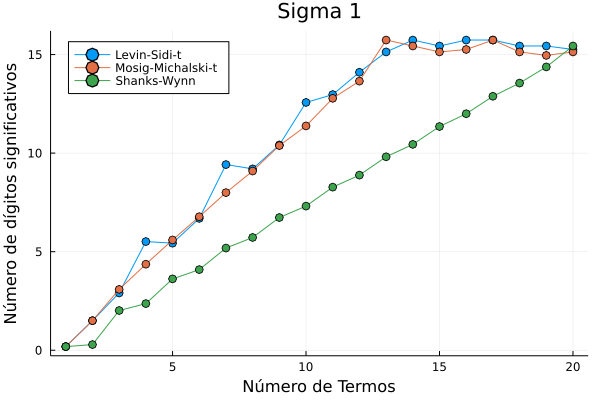

In [13]:
N = 20
y0, y_levin, y_shanks, y_momi = rodar_casos(N, soma_s1, "t", 2)
tv = res_s1

plot(xlabel="Número de Termos", ylabel="Número de dígitos significativos", title="Sigma 1", legend=:topleft)
plot!(@. -log10(abs((y_levin - tv) / tv)); marker=:o, label="Levin-Sidi-t")
plot!(@. -log10(abs((y_momi - tv) / tv)); marker=:o, label="Mosig-Michalski-t")
plot!(@. -log10(abs((y_shanks - tv) / tv)); marker=:o, label="Shanks-Wynn")

O primeiro somatório $\Sigma_1$ tem convergência alternada. O desempenho dos algorítimos de extrapolação de Levin-Sidi e de Mosig-Michalski são quase idênticos e melhor que o de Shanks-Wynn.

#### Sigma 2

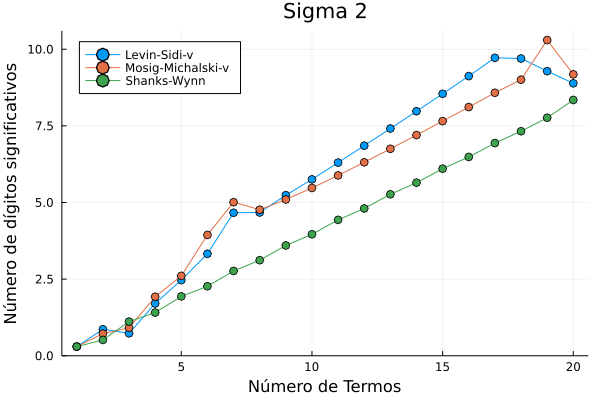

In [14]:
y0, y_levin, y_shanks, y_momi = rodar_casos(N, soma_s2, "v", 2)
tv = res_s2

plot(xlabel="Número de Termos", ylabel="Número de dígitos significativos", title="Sigma 2", legend=:topleft)
plot!(@. -log10(abs((y_levin - tv) / tv)); marker=:o, label="Levin-Sidi-v")
plot!(@. -log10(abs((y_momi - tv) / tv)); marker=:o, label="Mosig-Michalski-v")
plot!(@. -log10(abs((y_shanks - tv) / tv)); marker=:o, label="Shanks-Wynn")

Para a série $\Sigma_2$ com convergência monótona linear, as mesmas observações que as feitas para $\Sigma_1$ se aplicam, porém a convergência é muito mais lenta.

Para esta série, a acurácia diminui no final do gráfico para os algorítimos de Levin-Sidi e Mosig-Michalski. Tal fato não condiz com o resultado apresentado no artigo de [Michalski & Mosig (2016) [1]](#1). Não sei dizer se isto aconteceu, por exemplo, por causa de um erro nos índices usados dos códigos acima...

#### Sigma 3

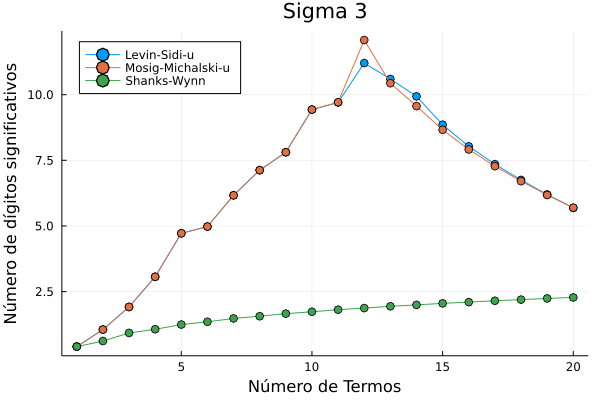

In [15]:
y0, y_levin, y_shanks, y_momi = rodar_casos(N, soma_s3, "u", 1)
tv = res_s3

plot(xlabel="Número de Termos", ylabel="Número de dígitos significativos", title="Sigma 3", legend=:topleft)
plot!(@. -log10(abs((y_levin - tv) / tv)); marker=:o, label="Levin-Sidi-u")
plot!(@. -log10(abs((y_momi - tv) / tv)); marker=:o, label="Mosig-Michalski-u")
plot!(@. -log10(abs((y_shanks - tv) / tv)); marker=:o, label="Shanks-Wynn")

Para a terceira série $\Sigma_3$, que tem convergência monótona logarítimica, novamente o desempenho dos algorítimos de Levin-Sidi e Mosig-Michalski são quase idênticos, contudo a convergência apresentada por eles não é monótona, diminuindo a acurácia a partir do 13º termo. Isto é causado pela instabilidade numérica dos algorítimos do tipo Levin para transformadas de ordem alta, causada por erros de cancelamento catastrófico que são esperados no caso de convergência monótona. O desempenho do algorítimo de Shanks-Wynn é muito ruim e não chega a 3 dígitos de acurácia.

Novamente, o gráfico produzido aqui não é igual àquele apresentado po [Michalski & Mosig (2016) [1]](#1). Aqui, chega-se a 12 dígitos de acurácia com 12 termos para o algorítimo de Mosig-Michalski, enquanto no artigo referido ela não supera 11 dígitos.

Os resultados acima demonstram que os algorítimos de Levin-Sidi e Mosig-Michalski são poderosos e versáteis para acelerar a convergência de séries numéricas. É recomendado que mais de um algorítimo seja testado ao lidar com um conjunto novo de problemas e que o algorítimo de Shanks-Wynn esteja entre eles por ele ser robusto e, no geral, eficiente.

## Método de Partição-Extrapolação para integrais de cauda oscilatórias

Para integração das caudas das integrais de Sommerfeld, combinam-se métodos de quadraturas progressivas, como a regra DE, e os métodos de extrapolação discutidos acima.

Considere uma integral $S$ feita sobre o eixo real com um integrando $f(\xi)$ oscilatório, podendo ter convergência lenta ou ser divergente. Calcula-se $S$ como o limite de uma sequência de somas parciais, conforme a seguir, sendo $\xi_{-1} = a$. Os pontos $\xi_i$ selecionados sãos os zeros de $f(\xi)$.

$$
S = \int_ a^\infty f(\xi)\, d\xi = \lim_{n \to \infty} \sum_{i=0}^n \int_{\xi_{i-1}}^{\xi_i} f(\xi)\, d\xi
$$

Esta metodologia de particionar a integral e aplicar extrapolação à série resultante é chamada de Método de Partição-Extrapolação (PE).

Primeiro, investiga-se o comportamento dos restos $r_n$ para fazer uma extrapolação eficiente.

$$
r_n = S_n - S = - \int_{\xi_n}^\infty f(\xi) \, d\xi
$$

Assumindo $\xi > b > a$, expressa-se $f(\xi) \approx g(\xi)\, p(\xi)$, onde $g(\xi)$ tem uma expanssão assintótica

$$
g(\xi) \sim \frac{e^{-\xi \, \zeta}}{\xi^\alpha} \sum_{j = 0}^\infty a_j \xi^{-j}, \quad \xi \to \infty,
$$

com o parâmetro $\zeta \ge 0$, enquanto $p(\xi)$ é periódica com um meio período $q$ tal que

$$
p(\xi + q) = - p(\xi)
$$

Desta forma, podemos assumir pontos equidistantes
$$
\xi_k = b + k q, \quad k = 0, 1, \dots,
$$

onde $b$ é o primeiro zero de $p(\xi)$. A partir disto, deduz-se

$$
r_n \sim -(-1)^n e^{-nq\zeta} \sum^\infty_{j=0} a_j \int_b^\infty \frac{p(t) e^{-t \zeta}}{(t + nq)^{\alpha + j}} dt.
$$

Fazendo uma expansão em série de Taylor em $t=b$ do denominador do integrando acima, chega-se a uma expansão do tipo Poincaré
$$
r_n \sim \omega_n \sum^\infty_{j=0} c_j \xi_n^{-j},
$$

onde $c_j$ são $n$ coeficientes independentes e $\omega_n$ são as estimativas do resto, dadas por
$$
\omega_n = (-1)^{n+1} \frac{e^{-nq\zeta}}{\xi_n^\alpha}.
$$

Os pontos $\xi_n$ podem ser substituídos pelos pontos de interpolação $x_n$ com fator de deslocamento $\beta = b / q$. Usando as duas expressões acima para computar o [limite $\lambda$](#lambda), obtendo-se $\lambda = -e^{-q\zeta}$, o que indica que a sequência $\{S_n\}$ é alternada e linearmente convergente, portanto todos os métodos do tipo Levin e o algorítimo de Shanks-Wynn são aplicáveis para acelerar a convergência. Usando a estimativa do resto $\omega_n$ em fórmula fechada, deduzida acima, no algorítimo de Levin-Sidi e Mosig-Michalski, deduz-se a *variante-a* destes métodos. O parâmetro $\Omega_k$ no algorítimo de Mosig-Michalski se torna
$$
\Omega_k = \frac{\omega_k}{\omega_{k-1}} = -e^{-q\zeta} \left ( \frac{x_{k-1}}{x_k} \right )^\alpha, \quad k \ge 1,
$$

sendo $\Omega_0 = 0$ e os parâmetros do algorítimo $\sigma = 0$ e $\mu = 2$.

Como exemplo, considere a integral
$$
I_\nu(a,z,\rho) = \int_a^\infty e^{-\xi z} J_\nu (\xi \rho) \xi^\nu d\xi = \frac{(2 \rho)^\nu \, \Gamma(\nu + 1/2)}{(z^2 + \rho^2)^{\nu + 1/2} \sqrt{\pi}} - \int_0^a e^{-\xi z} J_\nu (\xi \rho) \xi^\nu d\xi.
$$

Para $\nu = 0,1$ e $2$, as integrais $I_\nu(a,z,\rho)$ se assemelham à forna estática das integrais de cauda que aparecem no cômputdo de campos eletromagnéticos in meios estratificados. Com $z=0$ e $\nu =1,2$, as integrais do lado esquerdo divergem, mas são definidas no sentido da [Soma de Abel](https://pt.wikipedia.org/wiki/S%C3%A9rie_divergente#Soma_de_Abel) (é possível [redefinir o somatório como uma série de potências convergente](https://planetmath.org/abelsummability)).

**Nota:** [Michalski & Mosig (2016) [1]](#1) apresentam a fórmula acima usando um [duplo fatorial](https://pt.wikipedia.org/wiki/Duplo_fatorial), válida para valores inteiros de $\nu$. Eu escolhi apresentar a fórmula mais geral usando a [Função Gama](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_gama), assim como apresentado por [Gradshteyn & Ryzhik (2007, página 1089, equação 6.623.1)](#3), válida para qualquer valor de $\nu$.

Tendo em vista a forma assintótica da função de Bessel
$$
J_\nu (\xi \rho) \sim \sqrt{\frac{2}{\pi \xi \rho}} \cos(\xi \rho - \nu \pi/2 - \pi/4),\quad z\to\infty,
$$

$I_\nu(a,z,\rho)$ se encaixa no escopo do método PE com $\zeta = z$, $\alpha = 1/2 - \nu$, e $q = \pi/\rho$. A escolha natural de pontos de quebra $\xi_i$ para as integrais parciais são, neste caso, os zeros consecutivos de $J_\nu (\xi \rho)$ (Partição Longman). Contudo, os zeros extados da função de Bessel não tem fórmula fechada, necessitando de processos iterativos. Por isto, outras alternativas para escolher $\xi_i$ foram propostas, tal como a partição de Lyness, que usa zeros assintóticos baseados na expansão assintótica da função de Bessel (vide acima). Há, também, a partição de Sidi, que usa nós equidistantes separados pelo meio período $q$. A partição de Sidi é a mais simples, porém não confiável para certos valores de $\rho$ para os quais as somas parciais deixam de ser estritamente alternadas, o que leva a uma degradação do desempenho do método. Contudo, [Michalski & Mosig (2016)](#1) afirmam que este problema não aparece se o limite inferior de integração $a$ for escolhido como o primeiro zero da função de Bessel que seja maior do que o $a$ original.

O código a seguir calcula $I_2(5.13562, 0, 1)$ como uma sequência de somas paricais acelerada pela partição-extrapolação de Sidi e compara com o valor das somas parciais sem aceleração de convergência (normal).

In [65]:
function part_extrap_levin_sidi(v, a, z, p, tol, kmax=10)
    fun(x) = exp(-x * z) * besselj(v, x * p) * x^v
    q = pi / p
    X = zeros(kmax + 2)
    A = zeros(kmax + 1)
    B = copy(A)
    X[1] = a
    s = 0.0
    old = 0.0
    val = 0.0
    for k = 0:kmax
        X[k + 2] = X[k + 1] + q
        u, E = quadde(fun, X[k+1], X[k+2])
        s = s + u
        w = u
        val = levin_sidi(k, s, w, X, A, B)
        if k > 1 && abs(val - old) < tol * abs(val)
            println("convergiu em k = ", k)
            break
        end
        old = val
    end
    return val, E
end

part_extrap_levin_sidi (generic function with 2 methods)

In [66]:
function part_extrap_mosig_michalski(v, a, z, p, tol, kmax=10)
    fun(x) = exp(-x * z) * besselj(v, x * p) * x^v
    q = pi / p
    alpha = 1/2 - v
    u = 2
    X = zeros(kmax + 2)
    R = zeros(kmax + 1)
    X[1] = a
    s = 0.0
    old = 0.0
    val = 0.0
    for k = 0:kmax
        X[k + 2] = X[k + 1] + q
        u, E = quadde(fun, X[k+1], X[k+2])
        s = s + u
        if k > 0
            Gk = -exp(-q * z) * (X[k] / X[k + 1])^alpha
        else
            Gk = 0
        end
        val = mosig_michalski(u, k, sk, Gk, X, R)
        if k > 1 && abs(val - old) < tol * abs(val)
            println("convergiu em k = ", k)
            break
        end
        old = val
    end
    return val, E
end

part_extrap_mosig_michalski (generic function with 2 methods)

In [64]:
function integral_v(v,a,z,p)
    y1 = (2 * p)^v * gamma(v + 1/2) / (sqrt(pi) * (z^2 + p^2)^(v + 1/2))
    f(x) = exp(-x * z) * besselj(v, x * p) * x^v
    y2, E = quadde(f, 0, a)
    return (y1 - y2), E
end
Sn, E = integral_v(2, 5.13562, 0, 1)  # valor "exato"

(-10.07948621951323, 1.710745459487585e-9)

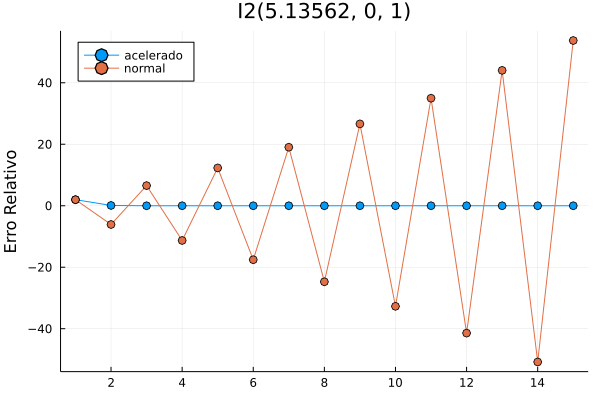

In [63]:
kmax = 15
soma_PE = zeros(kmax)
soma_SN = zeros(kmax)
let v = 2, a = 5.13562, z = 0, p = 1, tol = 1e-9
    fun(x) = exp(-x * z) * besselj(v, x * p) * x^v
    q = pi / 1
    X = zeros(kmax + 2)
    A = zeros(kmax + 1)
    B = copy(A)
    X[1] = a
    s = 0.0
    val = 0.0
    for k = 0:kmax-1
        X[k + 2] = X[k + 1] + q
        u, E = quadde(fun, X[k+1], X[k+2])
        s = s + u
        w = u
        val = levin_sidi(k, s, w, X, A, B)
        soma_PE[k+1] = val
        soma_SN[k+1] = u
    end
end
plot((soma_PE .- Sn) ./ Sn, marker=:o, label="acelerado", ylabel="Erro Relativo", title="I2(5.13562, 0, 1)")
plot!((soma_SN .- Sn) ./ Sn, marker=:o, label="normal", legend=:topleft)

## Conclusão

No artigo de referência deste texto [(Michalski & Mosig, 2016)](#1) fala-se, ainda, da regra DE de Ogata–Sugihara, que usa uma quadratura adaptativa para computar as integrais de Sommerfeld. Contudo, é reprotado que tal metodologia tem desempenho inferior à Partição-Extrapolação. Portanto, ela são será apresentada aqui.

Quando o interesse é computar campos nas zonas distantes (acima de algumas centenas de vezes o comprimento de onda), outros métodos, como o de [Descida mais íngreme](https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Laplace#Extens%C3%A3o_do_M%C3%A9todo_de_Laplace:_Descida_mais_%C3%ADngreme), são mais apropriados do que os apresentados acima; vide [Michalski (1985) [2]](#2).

## Referências

<a name="1"></a>[1] MICHALSKI, Krzysztof A.; MOSIG, Juan R. Efficient computation of Sommerfeld integral tails – methods and algorithms. **Journal of Electromagnetic Waves and Applications**, v. 30, n. 3, p. 281-317, 2016.

<a name="2"></a>[2] MICHALSKI, K. A. On the efficient evaluation of integral arising in the sommerfeld halfspace problem. In: **IEE Proceedings H (Microwaves, Antennas and Propagation)**. IET Digital Library, 1985. p. 312-318.

<a name="3"></a>[3] GRADSHTEYN I. S., RYZHIK IM. **Table of integrals, series, and products.** 7th ed. New York (NY): Academic Press; 2007.